/usr/local/lib/python3.7/dist-packages/skopt/sampler/sobol.py:250: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+1602=1602. 
  total_n_samples))
/usr/local/lib/python3.7/dist-packages/skopt/sampler/sobol.py:250: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+324=324. 
  total_n_samples))
/usr/local/lib/python3.7/dist-packages/skopt/sampler/sobol.py:250: UserWarning: The balance properties of Sobol' points require n to be a power of 2. 0 points have been previously generated, then: n=0+322=322. 
  total_n_samples))


Compiling model...
Building feed-forward neural network...
'build' took 0.035569 s



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/legacy_tf_layers/core.py:171: UserWarning: `tf.layers.dense` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Dense` instead.
  warnings.warn('`tf.layers.dense` is deprecated and '
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer_v1.py:1692: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
2022-09-22 17:33:25.056447: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:01:00.0 name: Quadro RTX 8000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 47.46GiB deviceMemoryBandwidth: 625.94GiB/s
2022-09-22 17:33:25.058967: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:24:00.0 name: Quadro RTX 8000 computeC

'compile' took 0.926802 s

Initializing variables...
Training model...

Step      Train loss                                                      Test loss                                                       Test metric   
0         [2.45e-01, 1.69e-02, 1.93e+00, 2.14e-01, 4.14e-01, 3.50e-02]    [2.48e-01, 1.71e-02, 1.93e+00, 2.14e-01, 4.14e-01, 3.50e-02]    [1.21e+00]    
1000      [2.87e-02, 5.66e-02, 9.81e-03, 1.66e-02, 7.23e-04, 5.62e-02]    [3.35e-02, 6.12e-02, 9.81e-03, 1.66e-02, 7.23e-04, 5.62e-02]    [9.75e-01]    
2000      [1.08e-02, 5.49e-02, 4.35e-03, 1.26e-03, 1.09e-02, 6.23e-02]    [1.20e-02, 5.88e-02, 4.35e-03, 1.26e-03, 1.09e-02, 6.23e-02]    [9.75e-01]    
3000      [6.97e-04, 9.86e-04, 5.89e-05, 1.03e-04, 4.87e-05, 3.03e-05]    [1.08e-03, 1.71e-03, 5.89e-05, 1.03e-04, 4.87e-05, 3.03e-05]    [9.07e-01]    
4000      [2.99e-04, 4.32e-04, 3.00e-05, 4.27e-05, 6.85e-06, 5.06e-06]    [5.69e-04, 8.78e-04, 3.00e-05, 4.27e-05, 6.85e-06, 5.06e-06]    [9.04e-01]    
5000      

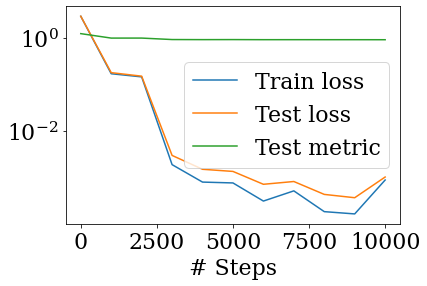

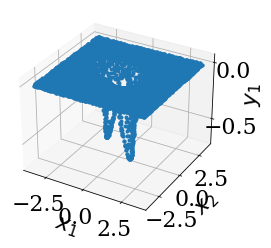

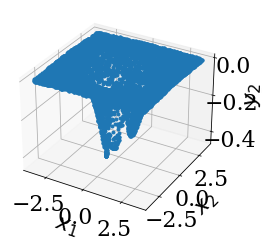

In [43]:
"""Backend supported: tensorflow.compat.v1, tensorflow, pytorch"""
import deepxde as dde
import numpy as np
import scipy
from scipy.special import jv, hankel1
from deepxde.backend import tf

#dde.config.real.set_float32()

# General parameters
weights = 1
epochs = 10000
learning_rate = 1e-3
#(3,350)
num_dense_layers = 3
num_dense_nodes = 350
activation = "tanh"

# Problem parameters
k0 = 2
wave_len = 2 * np.pi / k0
length = 2 * np.pi
R = np.pi / 4
n_wave = 20
h_elem = wave_len / n_wave
nx = int(length / h_elem)

d_absorb = np.pi /4.
length_pml = length + d_absorb

# Constantes del PML
#sigma0 = -np.log(1e-20) / (4 * d_absorb ** 3 / 3)
sigma0 = -np.log(1e-20) / (4 * length_pml ** 3 / 3)
omega = k0
box = np.array([[-length / 2, -length / 2], [length / 2, length / 2]])

# Computational domain

#outer = dde.geometry.Rectangle([-length  / 2, -length / 2], [length / 2, length / 2])
inner = dde.geometry.Disk([0, 0], R)

outer_pml = dde.geometry.Rectangle([- length_pml / 2, -length_pml / 2], [length_pml / 2, length_pml / 2])

#geom = outer - inner
geom = outer_pml - inner

# Exact solution
def sound_hard_circle_deepxde(k0, a, points):

    fem_xx = points[:, 0:1]
    fem_xy = points[:, 1:2]
    r = np.sqrt(fem_xx * fem_xx + fem_xy * fem_xy)
    theta = np.arctan2(fem_xy, fem_xx)
    npts = np.size(fem_xx, 0)
    n_terms = np.int(30 + (k0 * a) ** 1.01)

    u_sc = np.zeros((npts), dtype=np.complex128)
    for n in range(-n_terms, n_terms):
        bessel_deriv = jv(n - 1, k0 * a) - n / (k0 * a) * jv(n, k0 * a)
        hankel_deriv = n / (k0 * a) * hankel1(n, k0 * a) - hankel1(n + 1, k0 * a)
        u_sc += (
            -((1j) ** (n))
            * (bessel_deriv / hankel_deriv)
            * hankel1(n, k0 * r)
            * np.exp(1j * n * theta)
        ).ravel()
    return u_sc


def PML(x):
    def sigma(x, a, b):
        """sigma(x) = 0 if a < x < b, else grows cubically from zero.
        """

        def _sigma(d):
            heav = tf.numpy_function(np.heaviside, [d,0], tf.float32)
            return sigma0 * d ** 2 * heav

        return tf.cast(_sigma(a - x) + _sigma(x - b), tf.complex64)

    def dsigma(x, a, b):
        def _sigma(d):
            heav = tf.numpy_function(np.heaviside, [d,0], tf.float32)
            return 2 * sigma0 * d * heav

        return tf.cast(-_sigma(a - x) + _sigma(x - b), tf.complex64)

    # Understand BOX
    sigma_x = sigma(x[:, :1], box[0][0], box[1][0])
    AB1 = 1 / (1 + 1j / omega * sigma_x) ** 2
    A1, B1 = tf.math.real(AB1), tf.math.imag(AB1)

    dsigma_x = dsigma(x[:, :1], box[0][0], box[1][0])
    AB2 = -1j / omega * dsigma_x * AB1 / (1 + 1j / omega * sigma_x)
    A2, B2 = tf.math.real(AB2), tf.math.imag(AB2)

    sigma_y = sigma(x[:, 1:], box[0][1], box[1][1])
    AB3 = 1 / (1 + 1j / omega * sigma_y) ** 2
    A3, B3 = tf.math.real(AB3), tf.math.imag(AB3)

    dsigma_y = dsigma(x[:, 1:], box[0][1], box[1][1])
    AB4 = -1j / omega * dsigma_y * AB3 / (1 + 1j / omega * sigma_y)
    A4, B4 = tf.math.real(AB4), tf.math.imag(AB4)
    return A1, B1, A2, B2, A3, B3, A4, B4


# Definition of the pde
def pde(x, y):
    #Understanding the terms:
    #1 and 3 indexes are meant for 2nd order derivatives, 2 and 4 are meant for 1st order derivatives
    A1, B1, A2, B2, A3, B3, A4, B4 = PML(x)
    
    y0, y1 = y[:, 0:1], y[:, 1:2]

    y0_xx = dde.grad.hessian(y, x, component=0, i=0, j=0)
    y0_yy = dde.grad.hessian(y, x, component=0, i=1, j=1)

    y1_xx = dde.grad.hessian(y, x, component=1, i=0, j=0)
    y1_yy = dde.grad.hessian(y, x, component=1, i=1, j=1)
    
    # Changes
    # Agregar términos del PML fuera del cuadrado de largo length
    #basado en el scipt en dev

    loss_y0 = (
        (A1 * -y0_xx + A3 * -y0_yy - k0**2 * y0) /omega
        - (B1 * -y1_xx  + B3 * -y1_yy - k0**2 * y1) /omega
        +  omega * y0
    )
    loss_y1 = (
        (A1 * -y1_xx  + A3 * -y1_yy - k0**2 * y1 ) /omega
        + (B1 * -y0_xx  + B3 * -y0_yy - k0**2 * y0 ) /omega
        +  omega * y1
    )
    return loss_y0, loss_y1

def sol(x):
    result = sound_hard_circle_deepxde(k0, R, x).reshape((x.shape[0], 1))
    real = np.real(result)
    imag = np.imag(result)
    return np.hstack((real, imag))


# Boundary conditions
def boundary(x, on_boundary):
    return on_boundary

# donde es el borde outer al cual le queremos aplicar la condicion de borde externa? 
#Se asume outer_pml, con outer se obtienen NaN en los train and test loss
def boundary_outer(x, on_boundary):
    return on_boundary and outer_pml.on_boundary(x)


def boundary_inner(x, on_boundary):
    return on_boundary and inner.on_boundary(x)


def func0_inner(x):
    normal = -inner.boundary_normal(x)
    g = 1j * k0 * np.exp(1j * k0 * x[:, 0:1]) * normal[:, 0:1]
    return np.real(-g)


def func1_inner(x):
    normal = -inner.boundary_normal(x)
    g = 1j * k0 * np.exp(1j * k0 * x[:, 0:1]) * normal[:, 0:1]
    return np.imag(-g)


def func0_outer(x, y):
    # Changes
    # Cambiar BC a Dirichlet 0?
    result = -k0 * y[:, 1:2]
    return result


def func1_outer(x, y):
    # Changes
    # Cambiar BC a Dirichlet 0?
    result = k0 * y[:, 0:1]
    return result


# ABCs
bc0_inner = dde.NeumannBC(geom, func0_inner, boundary_inner, component=0)
bc1_inner = dde.NeumannBC(geom, func1_inner, boundary_inner, component=1)

# Changes
bc0_outer = dde.RobinBC(geom, func0_outer, boundary_outer, component=0)
bc1_outer = dde.RobinBC(geom, func1_outer, boundary_outer, component=1)

#bc0_outer = dde.DirichletBC(geom, lambda x: 0, boundary_outer, component=0)
#bc1_outer = dde.DirichletBC(geom, lambda x: 0, boundary_outer, component=1)

#Neumann? Issue ScattPINNs
#bc0_outer = dde.NeumannBC(geom, func0_inner, boundary_outer, component=0)
#bc1_outer = dde.NeumannBC(geom, func1_inner, boundary_outer, component=1)

bcs = [bc0_inner, bc1_inner, bc0_outer, bc1_outer]

loss_weights = [1, 1, weights, weights, weights, weights]

data = dde.data.PDE(
    geom,
    pde,
    bcs,
    num_domain=nx**2,
    num_boundary=8 * nx,
    num_test=5 * nx**2,
    solution=sol,
)
net = dde.maps.FNN(
    [2] + [num_dense_nodes] * num_dense_layers + [2], activation, "Glorot uniform"
)
model = dde.Model(data, net)

model.compile(
    "adam", lr=learning_rate, loss_weights=loss_weights, metrics=["l2 relative error"]
)
losshistory, train_state = model.train(epochs=epochs)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)


Relative error =  0.9393301408459016


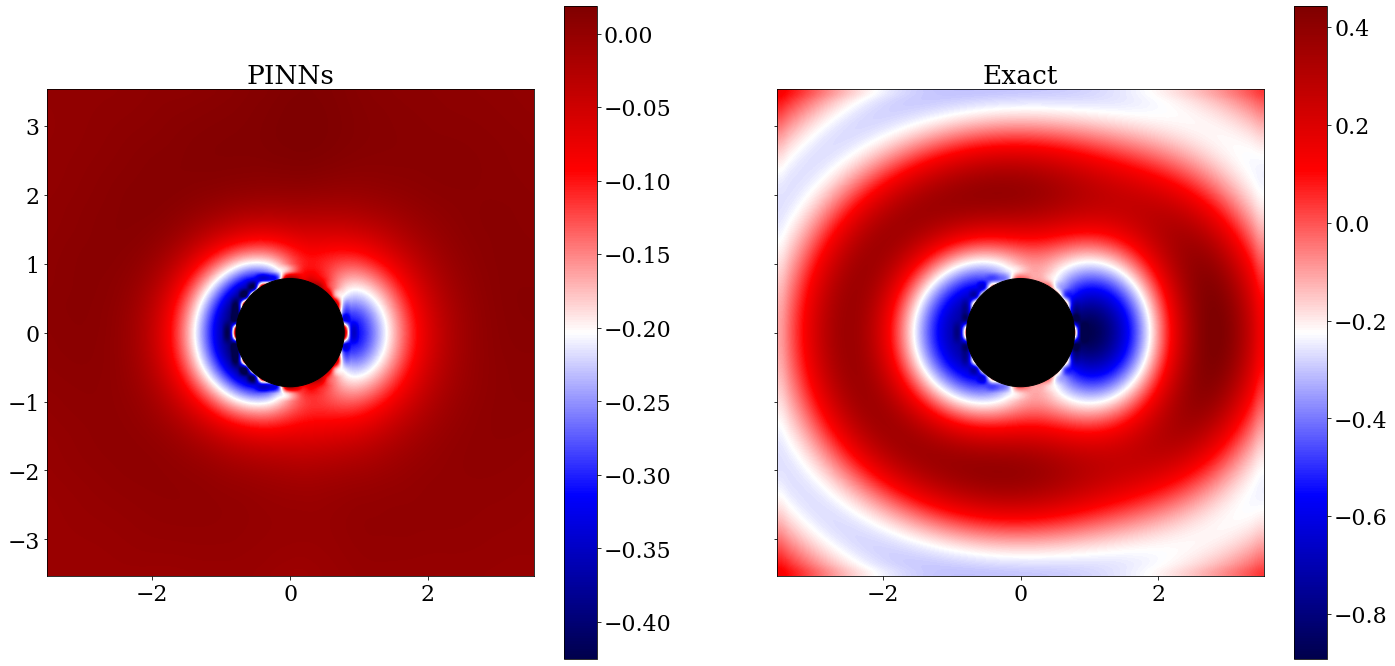

In [49]:
from matplotlib import pyplot as plt
'''            Evaluate field over a specified grid of points              '''
# Square grid with 10 points per wavelength in each direction
Nx = int(np.ceil(length/wave_len * 30))
Ny = Nx

# Grid points
xmin, xmax, ymin, ymax = [-length_pml/2, length_pml/2., -length_pml/2, length_pml/2]
plot_grid = np.mgrid[xmin:xmax:Nx * 1j, ymin:ymax:Ny * 1j]
points = np.vstack((plot_grid[0].ravel(),
                    plot_grid[1].ravel(),
                    np.zeros(plot_grid[0].size)))

points_2d = points[:2, :]

#in_circ = points[0, :]**2 + points[1, :]**2 <= (radius)**2
#in_circ_2d = points_2d[0, :]**2 + points_2d[1, :]**2 <= (radius)**2
#points[0, in_circ] = -radius - wave_len / 10
#points[1, in_circ] = radius + wave_len / 10
#points[2, in_circ] = 0.

# Bounding box tree etc for function evaluations

u_sca = model.predict(points[:2, :].T)
u_sca = u_sca[:, 0] + 1j* u_sca[:, 1]
#u_sca = u_sca[0] + 1j* u_sca[1]

u_exact = sol(points_2d.T)
u_exact = u_exact[:, 0] + 1j * u_exact[:, 1]

ide = np.sqrt(points_2d[0, :] ** 2 + points_2d[1, :] ** 2) <= R

u_exact[ide] = 0
u_sca[ide] = 0

u_exact = u_exact.reshape((Nx, Ny))
u_sca = u_sca.reshape((Nx, Ny))

'''                  Compare against analytical solution                    '''
# Uncomment to perform comparison, takes a few seconds to run




diff = u_exact-u_sca
error = np.linalg.norm(diff)/np.linalg.norm(u_exact)
print('Relative error = ', error)

'''                     Plot field and save figure                          '''
plt.rc('font', family='serif', size=22)



fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize = (24,12))

pcm = ax1.imshow(np.fliplr(np.imag(u_sca)).T,
           extent=[-length_pml/2, length_pml/2., -length_pml/2, length_pml/2],
           cmap=plt.cm.get_cmap('seismic'), interpolation='spline16', label='PINN')

circle = plt.Circle((0., 0.), R, color='black', fill=True)
ax1.add_patch(circle)
#ax1.axis('off')
fig.colorbar(pcm, ax = ax1)

pcm = ax2.imshow(np.fliplr(np.imag(u_exact)).T,
           extent=[-length_pml/2, length_pml/2., -length_pml/2, length_pml/2],
           cmap=plt.cm.get_cmap('seismic'), interpolation='spline16', label = 'Exact')

circle = plt.Circle((0., 0.), R, color='black', fill=True)
ax2.add_patch(circle)

#ax1.axis('off')
ax1.set_title('PINNs')
ax2.set_title('Exact')
fig.colorbar(pcm, ax = ax2)


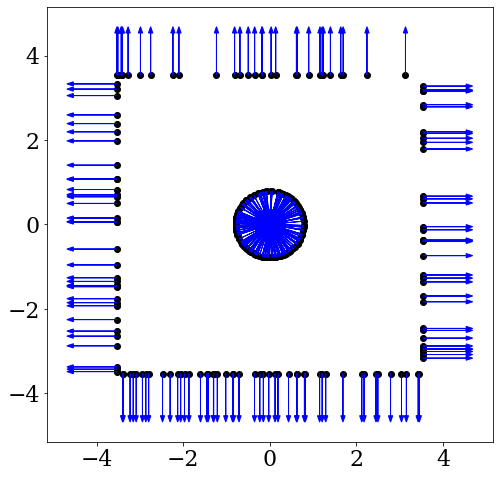

In [45]:
x = geom.random_boundary_points(8 * nx)
normal = geom.boundary_normal(x)

fig = plt.figure(figsize = (8,8))
plt.scatter(x[:,0], x[:,1], color = 'k')
npts = x.shape[0]
for i in range(npts):
    plt.arrow(x[i,0], x[i,1], normal[i,0], normal[i,1], color = 'b', head_width = .1)
